# 3D Overthrust data - global POCS with off-the-grid sampling
 
## Author: M.Ravasi

This notebook applies seismic interpolation to a 3D shot gather of the SEG/EAGE Overthrust 3D dataset. The data is subsampled along the x-axis and fully sampled along the y-axis. However small dithers are added to the receivers such that they do not fall directly on the sought after regular grid.

The EPOCS method will be applied here to handle off-the-grid receivers through a bilinear interpolation (instead of a simple restriction operator) and compared to our newly proposed PD-based POCS method. In both cases, compared to the example in `POCS_Overthrust-Offthegrid3D_windows.ipynb`, the data is not divided into windows and each window inverted separately; instead, all windows are jointly inverted. By doing so we allow the sampling operator to consider all traces in the reconstruction process (and therefore, if we consider a single window, its interpolation will be affected also by traces that fall just outside of the window itself).

The notebook is organized as follows:

- data loading
- direct arrival mask creation
- non-stationary data shifting (alternatively one could use NMO correction)
- amplitude-dependant weighting
- interpolation with various algorithms

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.io as sp_io
import pylops
import cupy as cp
cp_asarray = cp.asarray
cp_asnumpy = cp.asnumpy

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing           import *
from pylops.optimization.leastsquares  import *
from pylops.signalprocessing.patch3d   import patch3d_design

from pyproximal.proximal import *
from pyproximal.optimization.primal import *
from pyproximal.optimization.primaldual import *

from pypocs import threshold
from pypocs.visual import explode_volume
from pypocs.POCS import POCS
from pypocs.metric import *
from pypocs.interpolation import Callback

np.random.seed(5)

## Parameters

In [2]:
# Global parameters
perc_subsampling = 0.6 # percentage of subsampling
verb = False # verbosity during reconstruction

# Windows for patching
nwin = (32, 32, 32) # size of the window
nover = (8, 8, 6) # overlap between windows
nop = (64, 64, 64)
ixpatch, iypatch, itpatch = 1, 3, 2 # indices of the patch to visualize for QC

# Shift
vshift = 4000

# FK spectra
nfft=2**8

# Iterative solution
niter = 140
jsrnsave = 20

## Loading data

Let's load now our shot gather to interpolate

In [3]:
isrc = 3338*4 # selected source
print('Source:', isrc)

# model size
ny, nx, nz = 200, 330, 155

# data size
nt, nrxorig, nryorig = 1126, 177, 90
nrx, nry = 176, 80
dt = 0.004
dx = 20

data = np.fromfile('/mnt/datawaha_dig/Data/Overtrust3D/Data/p_full%d.rsf@' % isrc, dtype='float32')
data = data.reshape(nt+75, nrxorig * nryorig)[75:]
data = data.reshape(nt, nryorig, nrxorig).transpose(2,1,0) # y,x,t
data = data[:nrx, :nry, :500]/np.max(np.abs(data[:nrx, :nry, :500]))

ns, nr, nt = data.shape
print(data.shape)

# Time axis
t = np.arange(0, nt) * dt

Source: 13352
(176, 80, 500)


## Define subsampling operator

We consider here a more realistic scenario, where subsampling is performed along the x-axis and small dithers are added to the receivers such that they do not fall directly on the sought after regular grid (to mimic inevitable position errors in real acquisition).

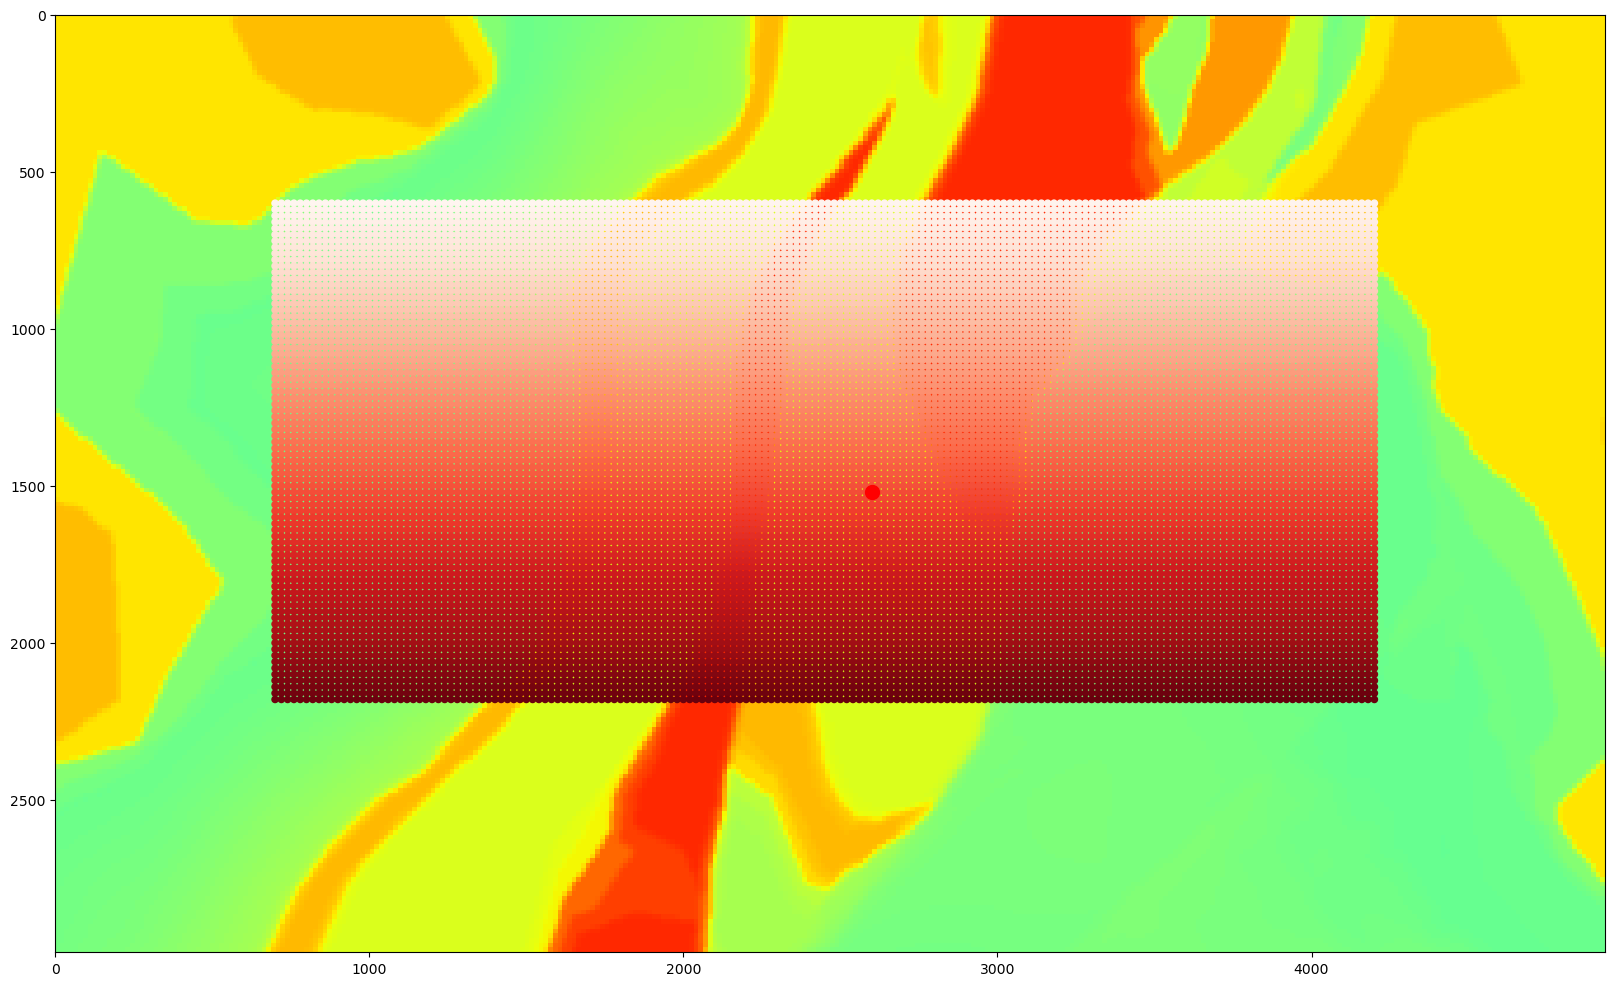

In [4]:
# Model
file = '/home/ravasim/Data/Overtrust3D/3-D_Overthrust_Model_Disk1/3D-Velocity-Grid/overthrust_small.bin'
y, x, z = np.arange(ny)*15., np.arange(nx)*15., np.arange(nz)*15.

traces = np.fromfile(file, dtype='f')
vp = traces.reshape(ny, nx, nz).astype(np.float32) # y,x,z arrangment

# Acquisition
srcx = np.arange(300,x[-1]-300, 20)
srcy = np.arange(300,y[-1]-300, 20)

SRCY, SRCX = np.meshgrid(srcy, srcx, indexing='ij')
SRCX, SRCY = SRCX.ravel(), SRCY.ravel()

recx = np.arange(700,x[-1]-700, 20)[:nrx]
recy = np.arange(600,y[-1]-600, 20)[:nry]

RECY, RECX = np.meshgrid(recy, recx, indexing='ij')
RECX, RECY = RECX.ravel(), RECY.ravel()

plt.figure(figsize=(20, 14))
plt.imshow(vp[:, :, 100], cmap='jet', clim=[1000, 3500], extent=(x[0], x[-1], y[-1], y[0]))
plt.scatter(RECX, RECY, c=np.arange(len(RECX)), s=20, cmap='Reds')
plt.scatter(SRCX[isrc], SRCY[isrc], c='r', s=100);

In [5]:
# Subsampling locations
Nsub = int(np.round(ns*perc_subsampling))

iy = np.arange(ns)
ix = np.arange(nr)

iygrid, ixgrid = np.meshgrid(iy, ix, indexing='ij')

iyava_y = np.random.randint(2, ns-2, Nsub)
iyava = np.tile(iyava_y, (nr, 1)).ravel()
ixava = np.tile(np.arange(nr), (Nsub, 1)).T.ravel()

mask2d = np.zeros((ns, nr))
mask2d[iyava, ixava] = 1
iava2d = np.where(mask2d.ravel()==1)[0]

mask3d = np.zeros((ns, nr, nt))
mask3d[iyava, ixava, :] = 1
iava3d = np.where(mask3d.ravel()==1)[0]

iyava = iygrid.ravel()[iava2d]
ixava = ixgrid.ravel()[iava2d]
Nsub = int(len(iava3d) / nt)

# Create restriction operator
Rop = Restriction(ns*nr*nt, iava=iava3d.ravel(), dtype='float64')
dottest(Rop)
mask = Rop.H*Rop*np.ones_like(data).ravel()
mask = mask.reshape(ns, nr, nt)

# Create bilinear operator
iyava_pert = iyava + np.random.uniform(-0.5, 0.5, Nsub)
ixava_pert = ixava + np.random.uniform(-0.5, 0.5, Nsub)
ixava_pert[ixava_pert<0] = 0.
ixava_pert[ixava_pert>nr-2] = nr-2
iava3d1 = np.vstack((iyava_pert, ixava_pert))

Bop = Bilinear(cp_asarray(iava3d1),(ns, nr, nt), dtype='float64')
dottest(Bop, backend='cupy')

Bop1 = Bilinear(iava3d1,(ns, nr), dtype='float64')
BopBopH = (Bop1 @ Bop1.H).todense()

Rop, Bop

(<3320000x7040000 Restriction with dtype=float64>,
 <3320000x7040000 Bilinear with dtype=float64>)

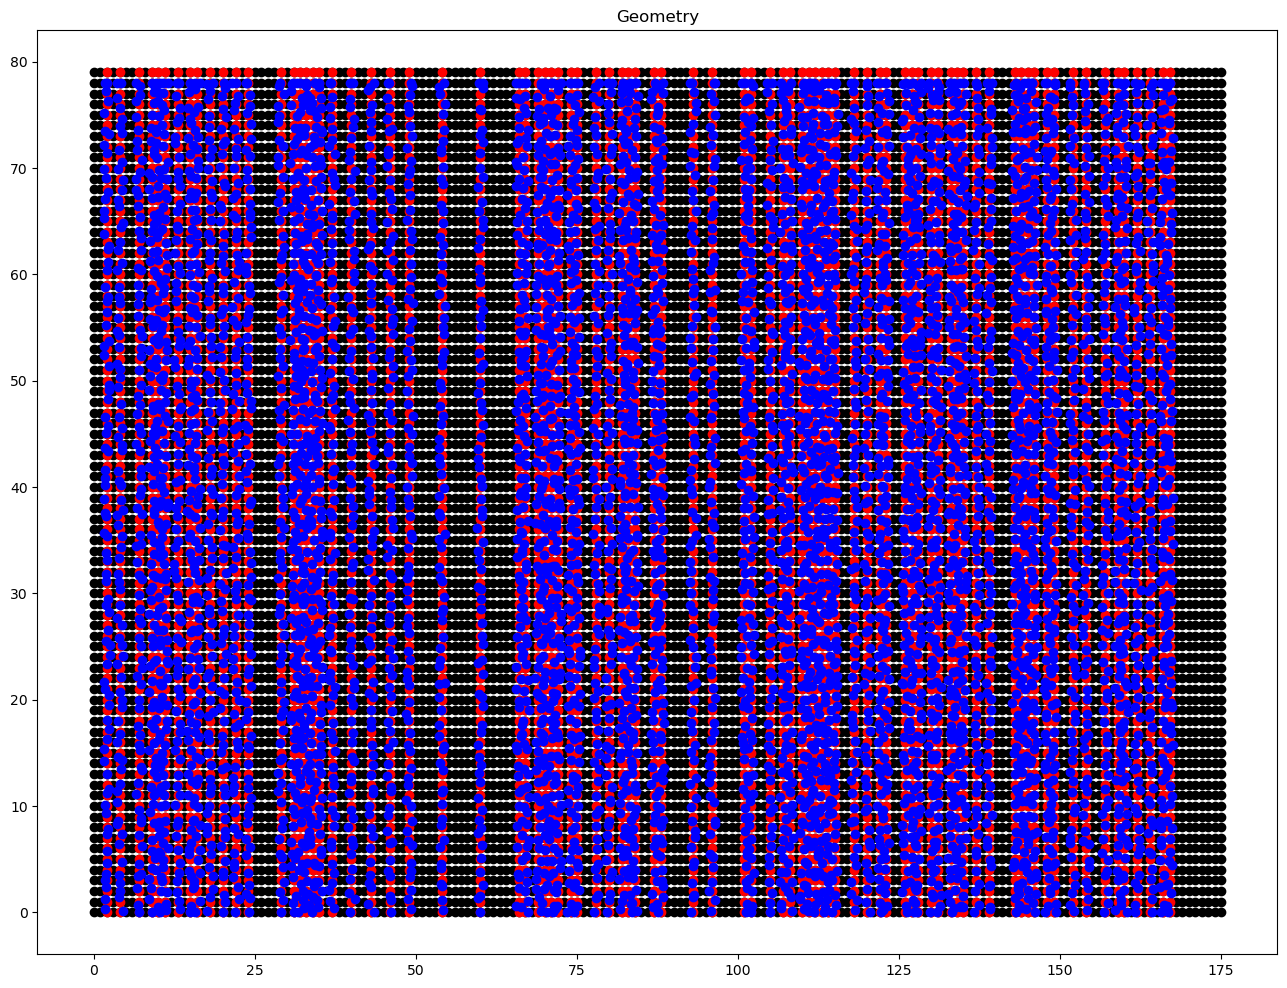

In [6]:
# Geometry 
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.scatter(iygrid, ixgrid, c='k')
ax.scatter(iyava, ixava, c='r')
ax.scatter(iava3d1[0], iava3d1[1], c='b')
ax.set_title('Geometry');

In [7]:
# Off-grid data
datasub = Bop*cp_asarray(data)
datamasked = Bop.H * datasub

datasub = cp_asnumpy(datasub)
datamasked = cp_asnumpy(datamasked)

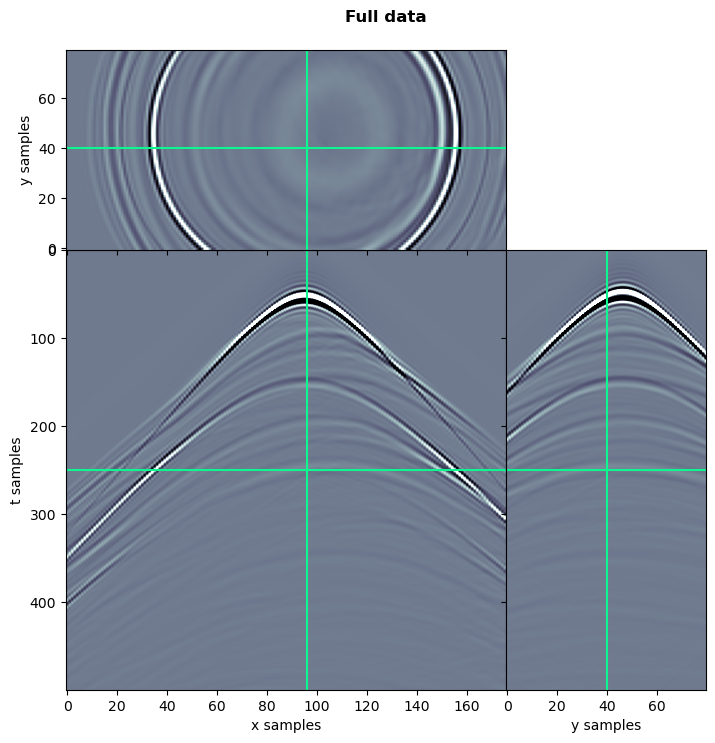

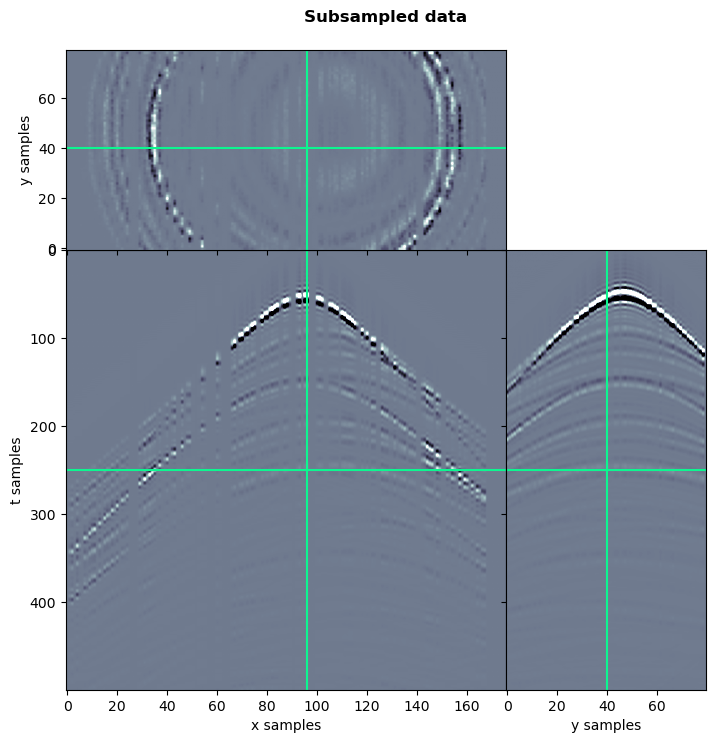

In [8]:
explode_volume(data.transpose(2, 0, 1), x=96, clipval=(-0.2,0.2), figsize=(8, 8), title='Full data')
explode_volume(datamasked.transpose(2, 0, 1), x=96, clipval=(-0.2,0.2), figsize=(8, 8), title='Subsampled data');

## Pre-processing

### Create direct arrival mask

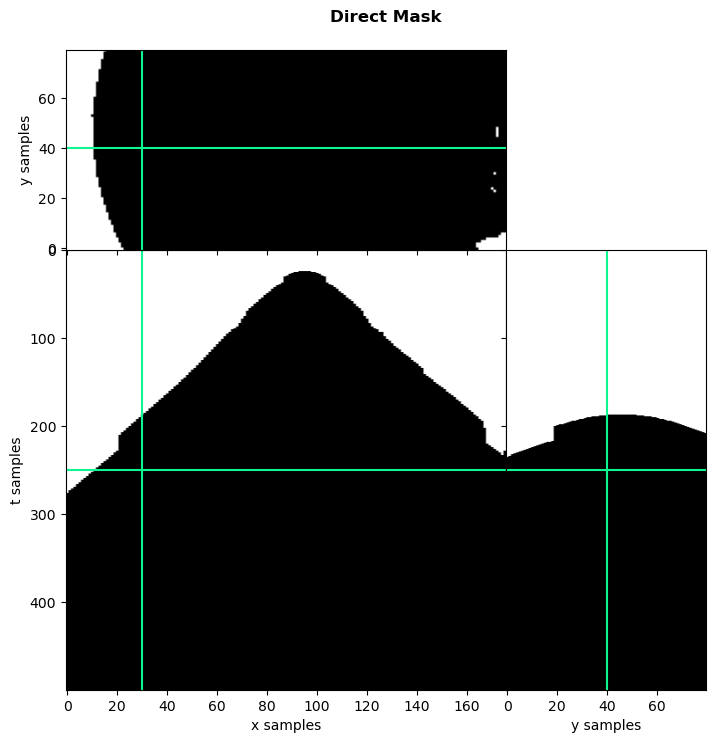

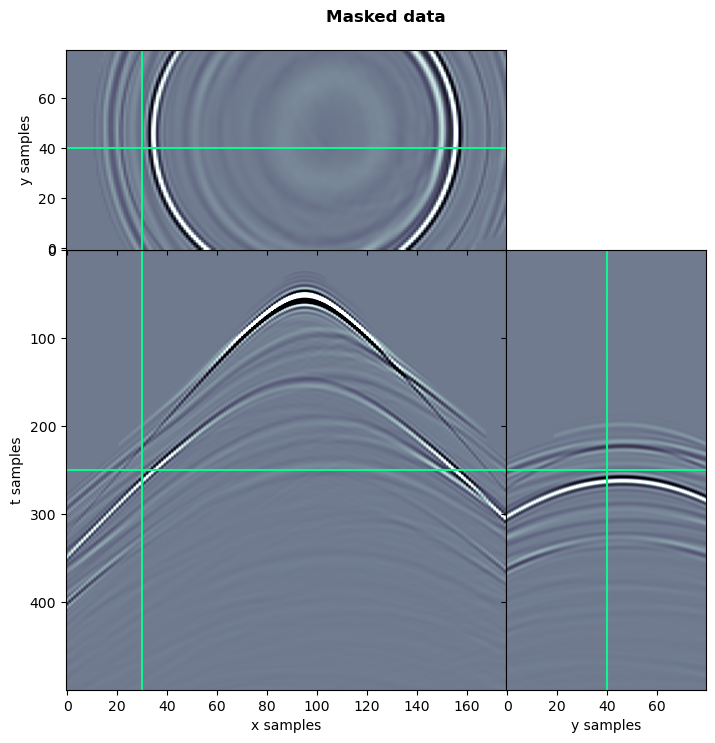

In [9]:
direct_mask = np.ones_like(data)
thresh = 0.02 * np.max(np.abs(data))
for iy in range(ns):
    for ix in range(nr):
        it = np.where(np.abs(data[iy, ix]) > thresh)[0]
        if len(it) > 0:
            direct_mask[iy, ix, :max(0, it[0] - 10)] = 0.

explode_volume(direct_mask.transpose(2, 0, 1), x=30, cmap='gray_r', clipval=(0, 1), figsize=(8, 8), title='Direct Mask')    
explode_volume((direct_mask*data).transpose(2, 0, 1), x=30, clipval=(-0.2,0.2), figsize=(8, 8), title='Masked data');

### Patched fk sparsyfing transform

In [10]:
dimsd = data.shape
nop1 = (nop[0], nop[1], nop[2]//2 + 1)

nwins, dims, mwins_inends, dwins_inends = patch3d_design(dimsd, nwin, nover, nop1)

F1op = FFTND(nwin, nffts=nop, real=True, dtype="complex64")
Srecop = Patch3D(F1op.H, dims, dimsd, nwin, nover, nop1, tapertype='cosine')

 468], end:[ 32  58  84 110 136 162 188 214 240 266 292 318 344 370 396 422 448 474
 500]
 594], end:[ 33  66  99 132 165 198 231 264 297 330 363 396 429 462 495 528 561 594
 627]


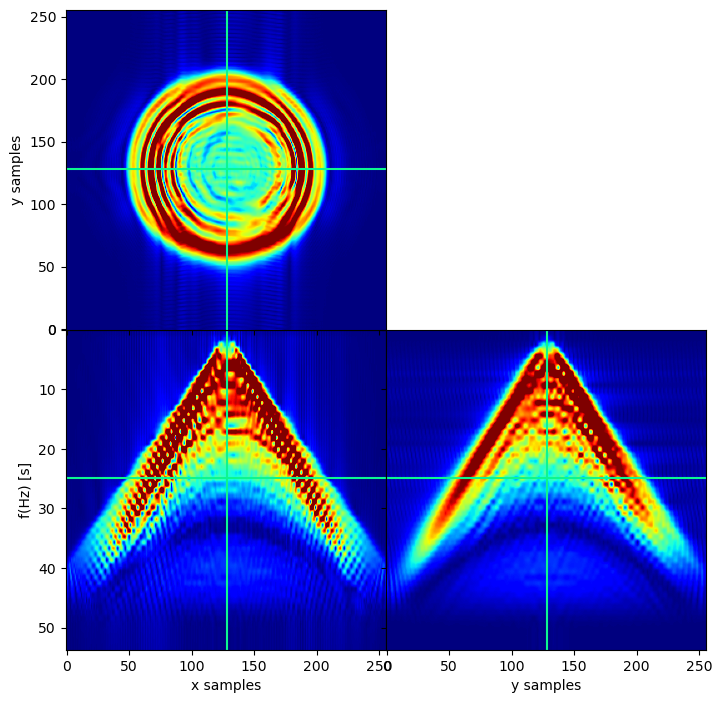

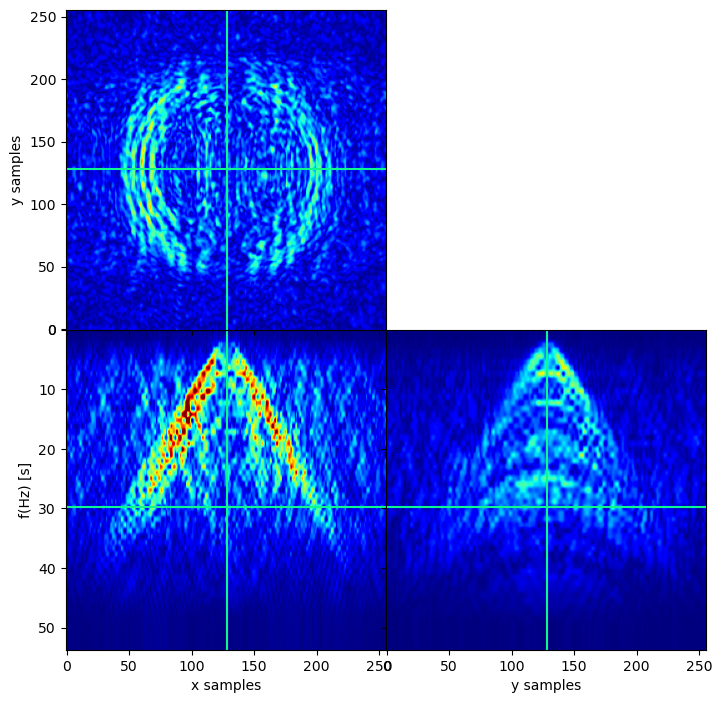

In [11]:
# FK spectra
FFTop = FFTND(dims=[ns, nr, nt], nffts=[nfft, nfft, nfft], sampling=[dx, dx, dt], real=True)

datafk = FFTop @ data
datamaskedfk = FFTop @ datamasked

explode_volume(np.fft.fftshift(np.abs(datafk[..., :55]),axes=(0,1)).transpose(2, 0, 1), t=25,
               tlim=[0,FFTop.fs[-1][55]], tlabel='f(Hz)',
               cmap='jet', figsize=(8, 8), clipval=(0,0.2))

explode_volume(np.fft.fftshift(np.abs(datamaskedfk[..., :55]),axes=(0,1)).transpose(2, 0, 1), t=30,
               tlim=[0,FFTop.fs[-1][55]], tlabel='f(Hz)',
               cmap='jet', figsize=(8, 8), clipval=(0,0.2));

### Shift data

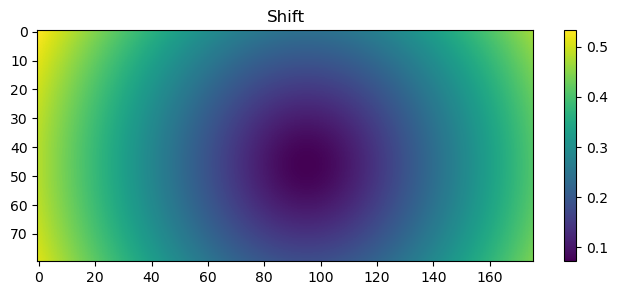

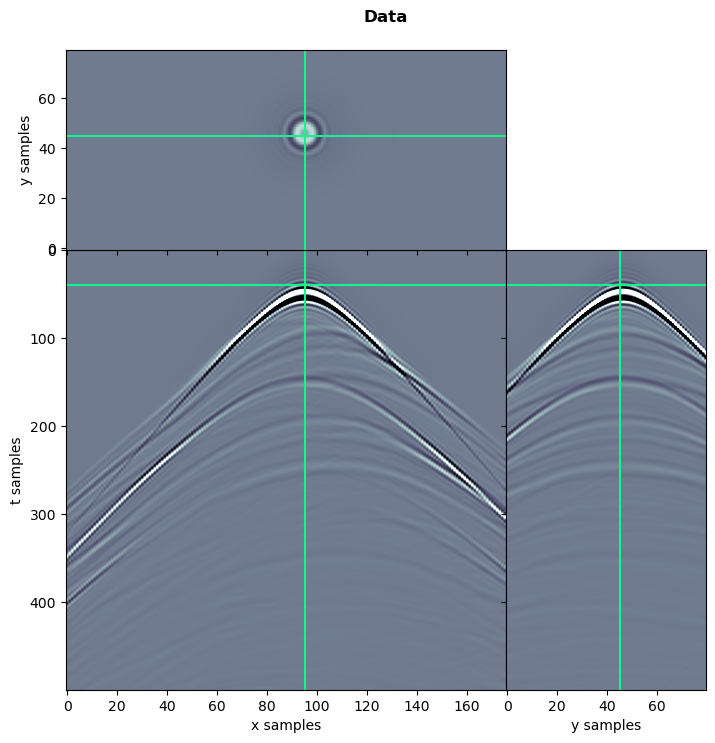

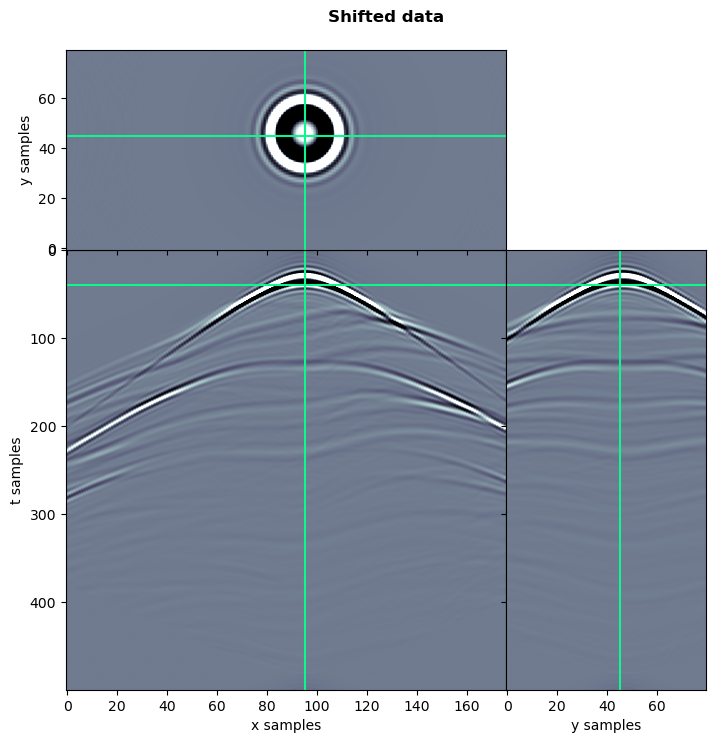

In [12]:
# Shift operator
shift = np.sqrt((300-10)**2 +
                (RECX.reshape(nry, nrx)-SRCX[isrc])**2 + 
                (RECY.reshape(nry, nrx)-SRCY[isrc])**2) / vshift

Shiftop = Shift((nrx, nry, nt), shift=-shift.T, sampling=dt, axis=2)

# Shift data
datashifted = np.real(Shiftop * data)
datareshifted = np.real(Shiftop.H * datashifted)

# Visualization
plt.figure(figsize=(8, 3))
plt.imshow(shift)
plt.axis('tight')
plt.colorbar()
plt.title('Shift')

explode_volume(data.transpose(2, 0, 1), t=40, x=95, y=45, clipval=(-0.2,0.2), figsize=(8, 8), title='Data')
explode_volume(datashifted.transpose(2, 0, 1), t=40, x=95, y=45, clipval=(-0.2,0.2), figsize=(8, 8), title='Shifted data');

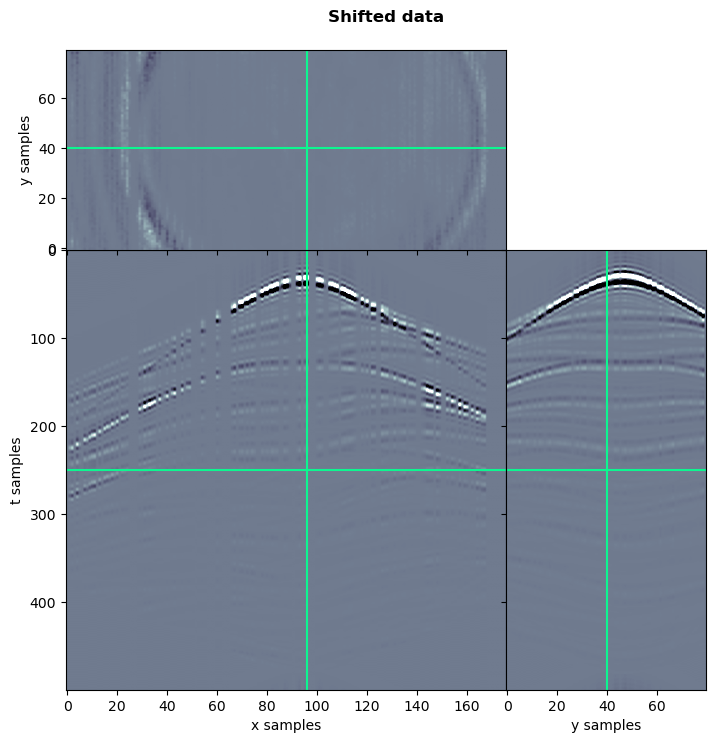

In [13]:
# Shift subsampled data
datashiftedsub = Bop*cp_asarray(datashifted)
datashiftedmasked = Bop.H * datashiftedsub

datashiftedsub = cp_asnumpy(datashiftedsub)
datashiftedmasked = cp_asnumpy(datashiftedmasked)

explode_volume(datashiftedmasked.transpose(2, 0, 1), x=96, clipval=(-0.2,0.2), figsize=(8, 8), title='Shifted data');

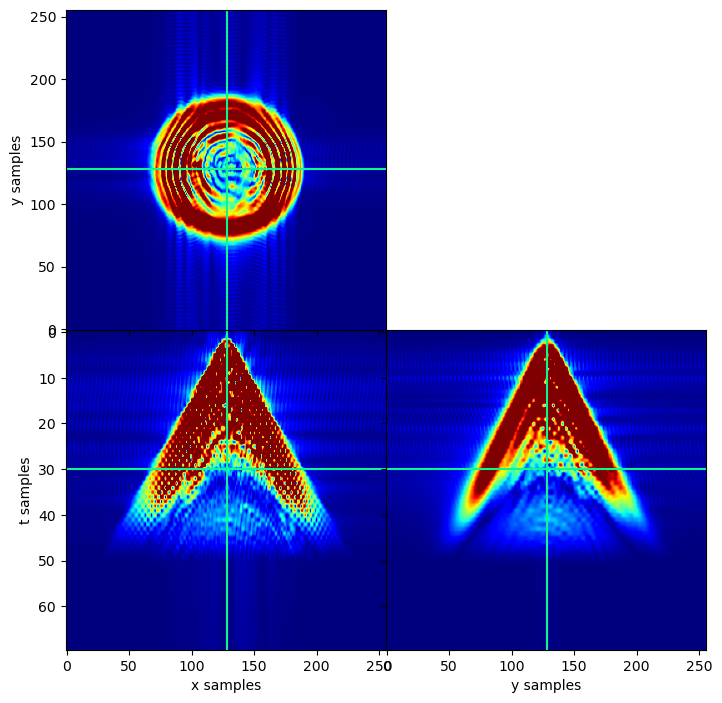

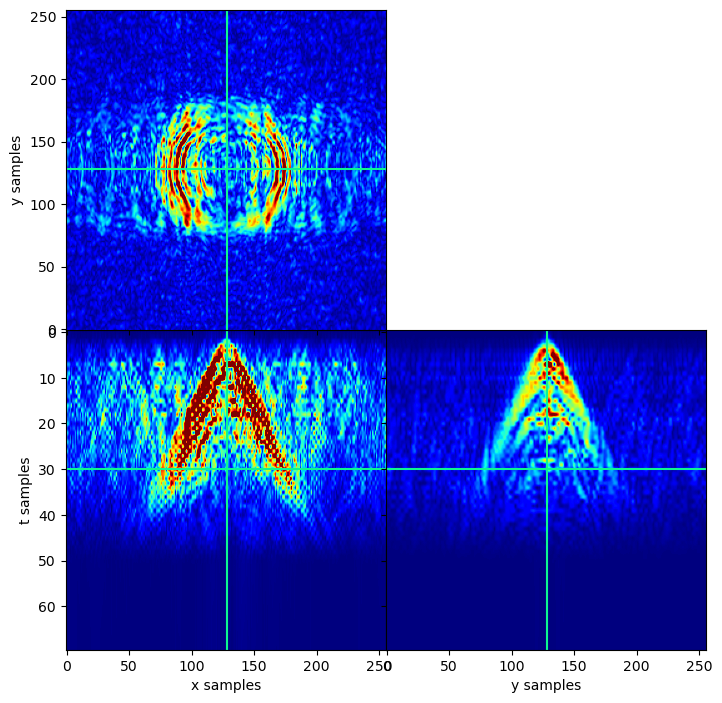

In [14]:
datashiftedfk = FFTop @ datashifted
datashiftedmaskedfk = FFTop @ datashiftedmasked

explode_volume(np.fft.fftshift(np.abs(datashiftedfk[..., :70]),axes=(0,1)).transpose(2, 0, 1), t=30,
               cmap='jet', figsize=(8, 8), clipval=(0,0.2))

explode_volume(np.fft.fftshift(np.abs(datashiftedmaskedfk[..., :70]),axes=(0,1)).transpose(2, 0, 1), t=30,
               cmap='jet', figsize=(8, 8), clipval=(0,0.2));

### Amplitude weights

Since we are reconstructing all windows together, we need to take into account the fact that there is a large dynamic range between the early and late arrivals. We do so by creating an amplitude-dependant weighting and applying it to the data to be interpolated. The original amplitudes are recovered in a post-processing step by renormalizing the reconstructed data by the inverse of such a normalization factor.

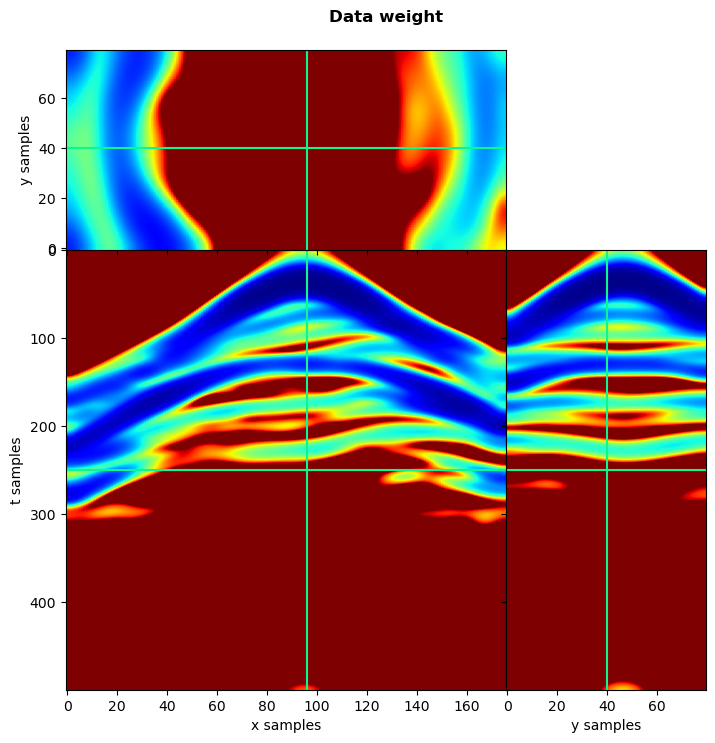

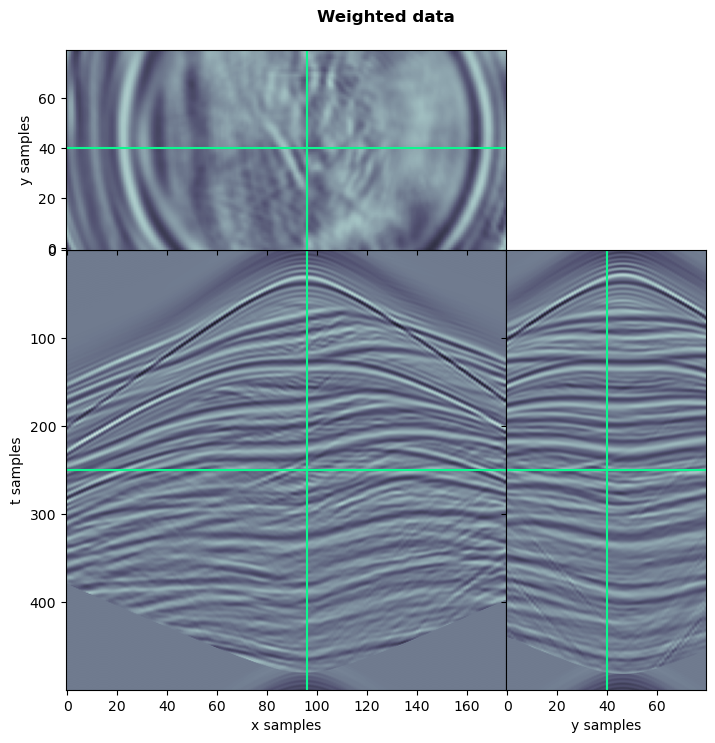

In [15]:
# Find normalization factors
weightshifted = 1./(sp.ndimage.gaussian_filter(np.abs(sp.signal.hilbert(datashifted)), sigma=4) + 1e-3)
weightshifted[weightshifted > 300] = 300 # remove infinite values when there is no signal
weightshifted /= (weightshifted.max() / 20)

explode_volume(weightshifted.transpose(2, 0, 1), x=96, figsize=(8, 8), clipval=(0,10), 
               cmap='jet', title='Data weight');

explode_volume((datashifted*weightshifted).transpose(2, 0, 1), x=96, figsize=(8, 8), clipval=(-0.2,0.2), 
               title='Weighted data');

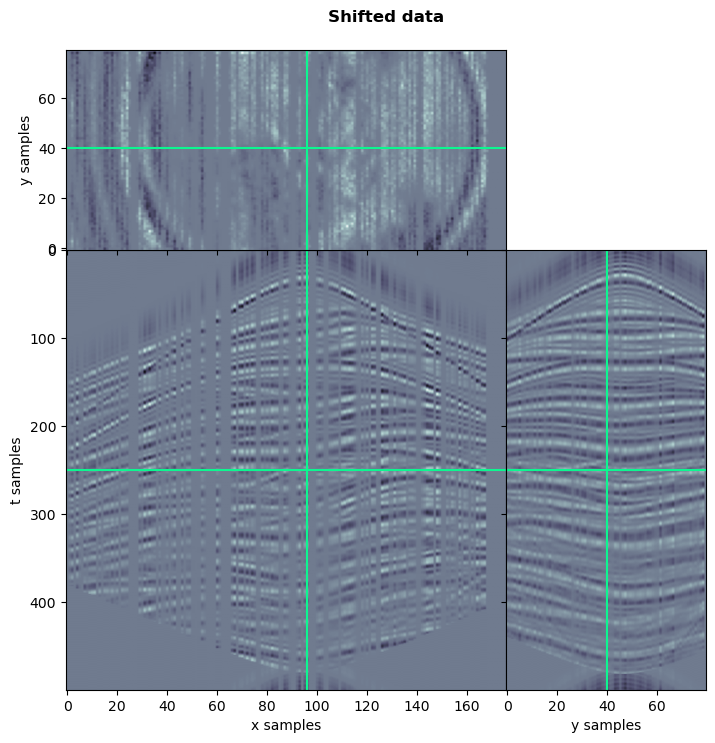

In [16]:
# Apply weighting with subsamp\led data
datashiftedsub = Bop*cp_asarray(datashifted*weightshifted)
datashiftedmasked = Bop.H * datashiftedsub

datashiftedsub = cp_asnumpy(datashiftedsub)
datashiftedmasked = cp_asnumpy(datashiftedmasked)

explode_volume(datashiftedmasked.transpose(2, 0, 1), x=96, clipval=(-0.2,0.2), 
               figsize=(8, 8), title='Shifted data');

## Run experiments

### EPOCS exponential with bilinear

In [17]:
# Threshold
pmax, pmin = 0.5, 0.01 # percentage of max

datashiftedsubmask = Bop.H @ cp.asarray(datashiftedsub).ravel()
ymax = float(np.max(np.abs(FFTop * datashiftedsubmask.ravel())))
thresh = [pmin * ymax, pmax * ymax]
thresh = threshold.exponential1(thresh[1], thresh[0], niter)

# Reconstruct data
xpocs, xpocs_hist, Xpocs_hist, errpocs, thresh_hist = \
    POCS(cp.asarray(datashiftedsub), np.ones((nrx,nry,nt)), Srecop, None, thresh, 
         niter, BOp=Bop, dinit=Bop.H * cp_asarray(datashiftedsub.ravel()),
         dtrue=cp_asarray(datashifted * weightshifted), masktrue=cp_asarray(1. / weightshifted),
         history=jsrnsave)    

ppocs = FFTop * xpocs.ravel()
ppocs = ppocs.reshape(nfft, nfft, nfft//2+1)

# Compute intermediate errors and SNRs
errpocs = [np.linalg.norm(datashifted-datashiftedmasked / weightshifted) / np.linalg.norm(datashifted)] + errpocs
snr_hist_epocs = 20 * np.log10(1/np.array(errpocs))

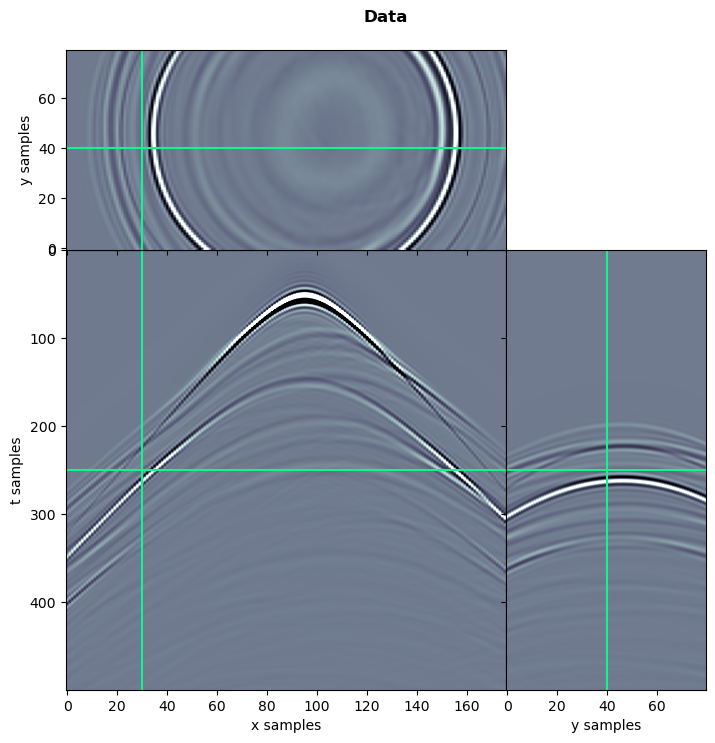

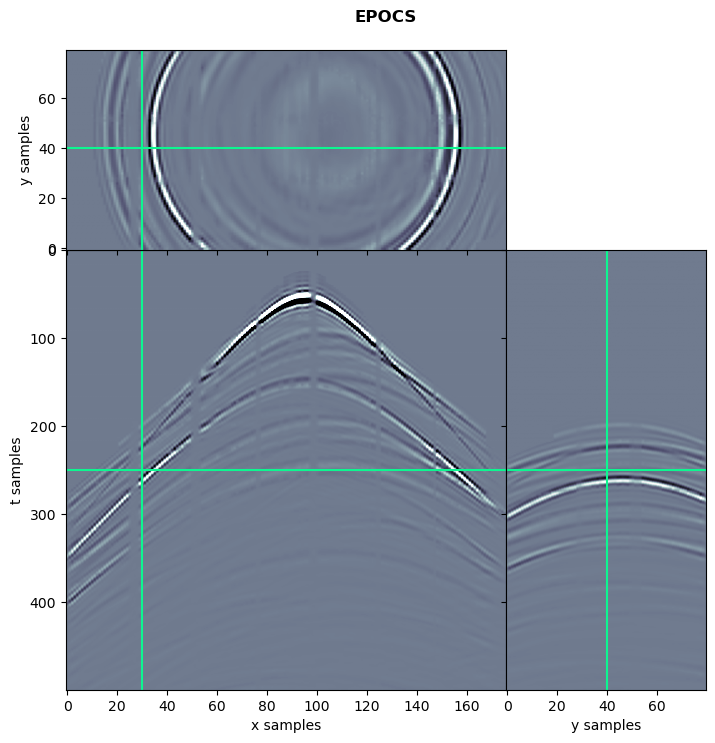

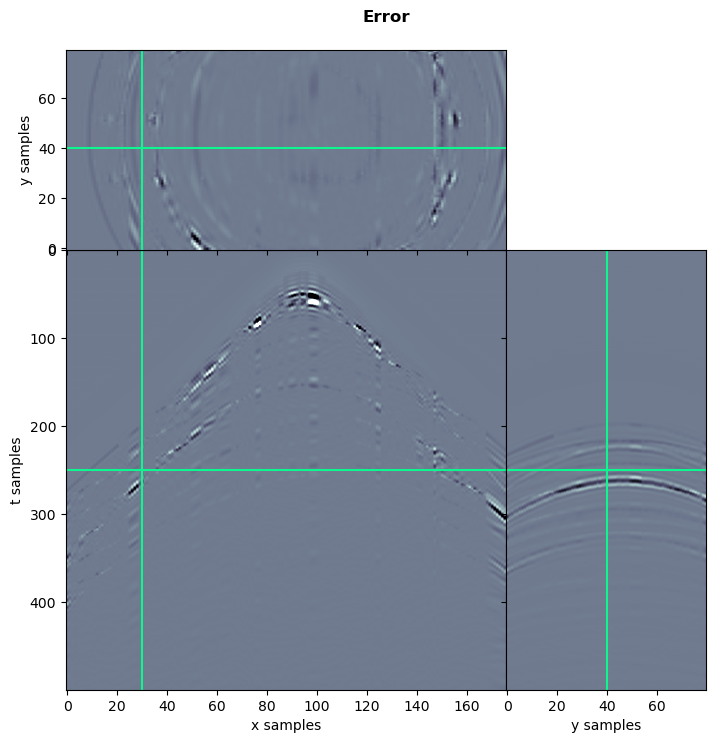

In [18]:
# Renormalize and shift back reconstructed data
datarec_epocsshiftedback = cp_asnumpy(np.real(Shiftop.H * (xpocs / cp_asarray(weightshifted)))) 

explode_volume(data.transpose(2, 0, 1), x=30, clipval=(-0.2,0.2), figsize=(8, 8), title='Data')
explode_volume((direct_mask*datarec_epocsshiftedback).transpose(2, 0, 1), x=30, clipval=(-0.2,0.2), 
               figsize=(8, 8), title='EPOCS')
explode_volume((direct_mask*datarec_epocsshiftedback).transpose(2, 0, 1) - data.transpose(2, 0, 1), x=30,
               clipval=(-0.2,0.2), figsize=(8, 8), title='Error');

In [19]:
metrics(data, direct_mask*datarec_epocsshiftedback, itmin=0, verb=True);

RMSE=0.3826346739211248, SNR=8.34431354501978


### PD exponential with bilinear (and 2 iters)

In [20]:
thresh = 0.01
laff = AffineSet(Bop, cp.asarray(datashiftedsub).ravel(), niter=2)
lort = L0(thresh)
tau, mu = .99, .99
callback = Callback(cp_asarray(datashifted * weightshifted).ravel(), history=jsrnsave, 
                    masktrue=cp_asarray(direct_mask / weightshifted).ravel(), backend="cupy")
cb = lambda xx: callback(xx)

xpd = \
    PrimalDual(laff, lort, Srecop.H, x0=Bop.H * cp_asarray(datashiftedsub.ravel()), 
               tau=tau, mu=mu, niter=niter, gfirst=True, show=False, callback=cb)

ppd = FFTop * xpd.ravel()
ppd = ppd.reshape(nfft, nfft, nfft//2+1)
errpd = [np.linalg.norm(datashifted-datashiftedmasked / weightshifted) / np.linalg.norm(datashifted)] + callback.err
snr_hist_pd = 20 * np.log10(1/np.array(errpd))

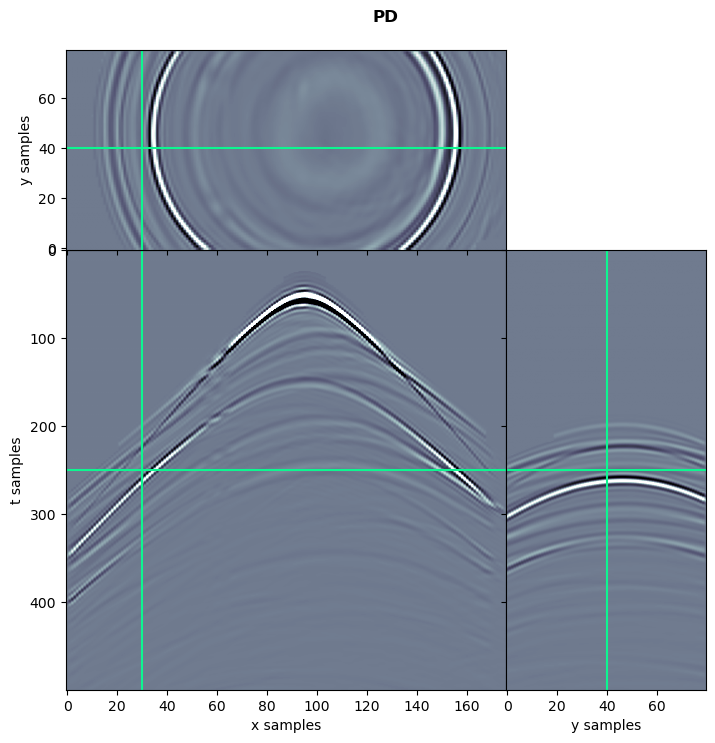

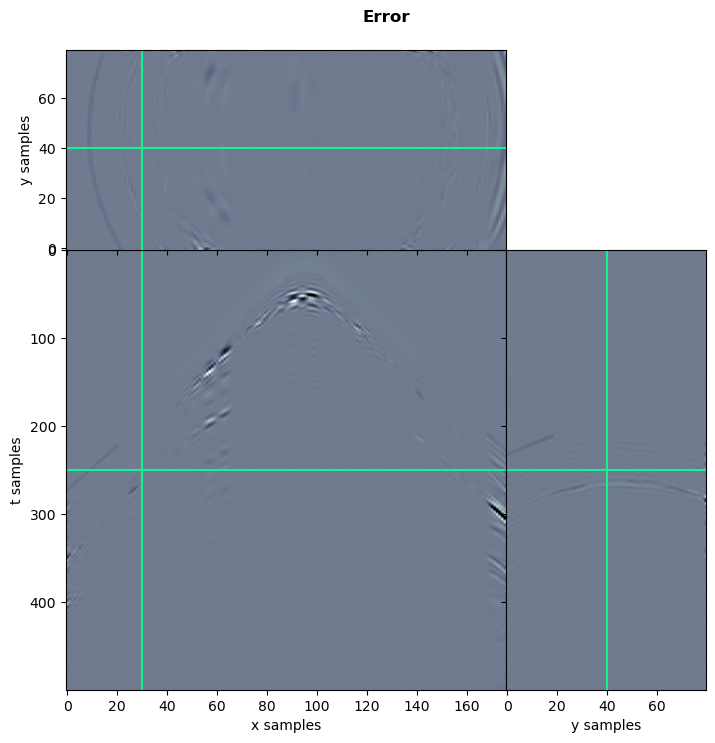

In [21]:
# Renormalize and shift back reconstructed data
datarec_pdshiftedback = cp_asnumpy(np.real(Shiftop.H * (xpd.reshape(nrx, nry, nt) / cp_asarray(weightshifted))))

explode_volume(data.transpose(2, 0, 1), x=30, clipval=(-0.2,0.2), figsize=(8, 8), title='Data')
explode_volume((direct_mask*datarec_pdshiftedback).transpose(2, 0, 1), x=30, clipval=(-0.2,0.2), 
               figsize=(8, 8), title='PD')
explode_volume((direct_mask*datarec_pdshiftedback).transpose(2, 0, 1) - data.transpose(2, 0, 1), x=30,
               clipval=(-0.2,0.2), figsize=(8, 8), title='Error');

In [22]:
metrics(data, direct_mask*datarec_pdshiftedback, itmin=0, verb=True);

RMSE=0.18343568614071712, SNR=14.730323429333774


In [23]:
# Save results
np.savez(f'../../experiments/Overthrust/Rec_offgrid{perc_subsampling}_joint.npz', 
         datarec_epocs=datarec_epocsshiftedback,
         datarec_pdinv=datarec_pdshiftedback,
         snr_epocs=snr_hist_epocs,
         snr_pd=snr_hist_pd)

## Visualization

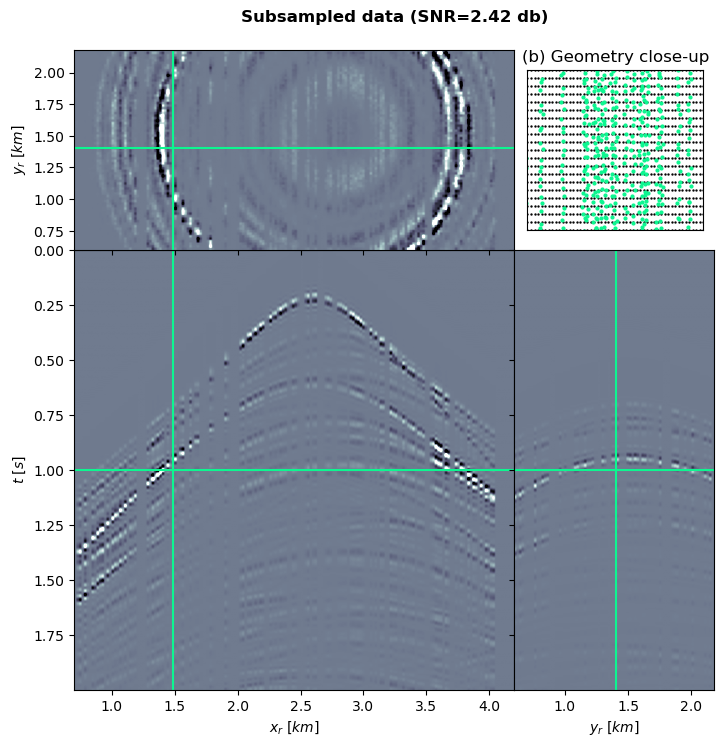

In [24]:
# Time gain
gain = t**1.5
gain = gain[:, np.newaxis, np.newaxis]
xplot = 39

_, snr = metrics(data, direct_mask*datamasked, itmin=0)
fig, axs = explode_volume(datamasked.transpose(2, 0, 1) * gain, x=xplot, 
                       tlim=[0, t[-1]], tlabel=r'$t$',
                       xlim=[recx[0]/1e3, recx[-1]/1e3], xlabel=r'$x_r$',
                       ylim=[recy[0]/1e3, recy[-1]/1e3], ylabel=r'$y_r$',
                       labels= (r'$[s]$', r'$[km]$', r'$[km]$'),
                       clipval=(-0.1,0.1), figsize=(8, 8), title=f'Subsampled data (SNR={snr:.2f} db)')

axins = axs[2].inset_axes([1.03, 0.1, 0.4, 0.8])
axins.set_xlim([50,100])
axins.set_ylim([50,30])
axins.set_xticks([])
axins.set_yticks([])

axins.scatter(iygrid, ixgrid, c='k', s=0.5)
axins.scatter(iava3d1[0], iava3d1[1], c='#0DF690', s=4)
axins.set_title('(b) Geometry close-up')
plt.savefig(f'../../figs/Overthrust/Offgrid_data.eps');

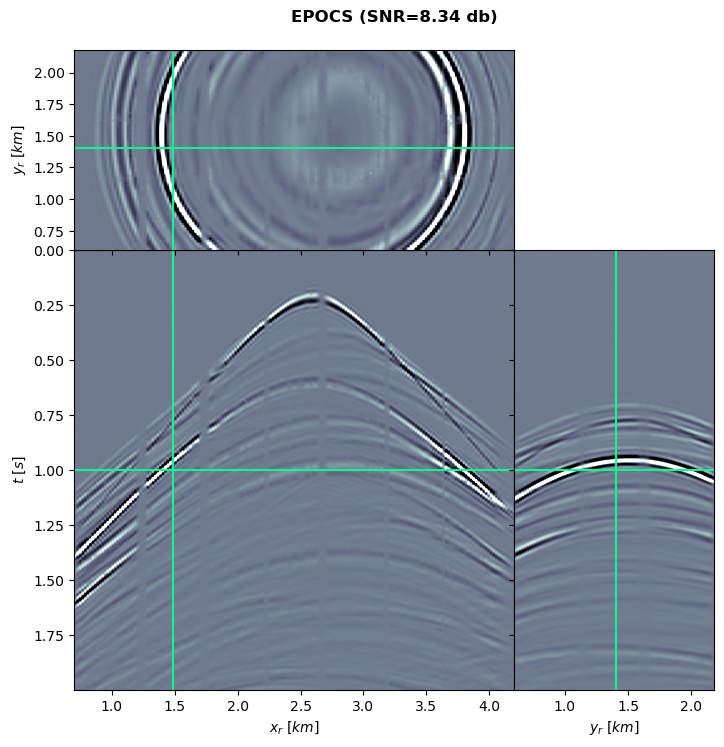

In [25]:
_, snr = metrics(data, direct_mask*datarec_epocsshiftedback, itmin=0)
fig, axs = explode_volume(datarec_epocsshiftedback.transpose(2, 0, 1) * gain, x=xplot, 
               tlim=[0, t[-1]], tlabel=r'$t$',
               xlim=[recx[0]/1e3, recx[-1]/1e3], xlabel=r'$x_r$',
               ylim=[recy[0]/1e3, recy[-1]/1e3], ylabel=r'$y_r$',
               labels= (r'$[s]$', r'$[km]$', r'$[km]$'),
               clipval=(-0.1,0.1), figsize=(8, 8), title=f'EPOCS (SNR={snr:.2f} db)')
plt.savefig(f'../../figs/Overthrust/Offgrid_EPOCSdata_sliding.eps');

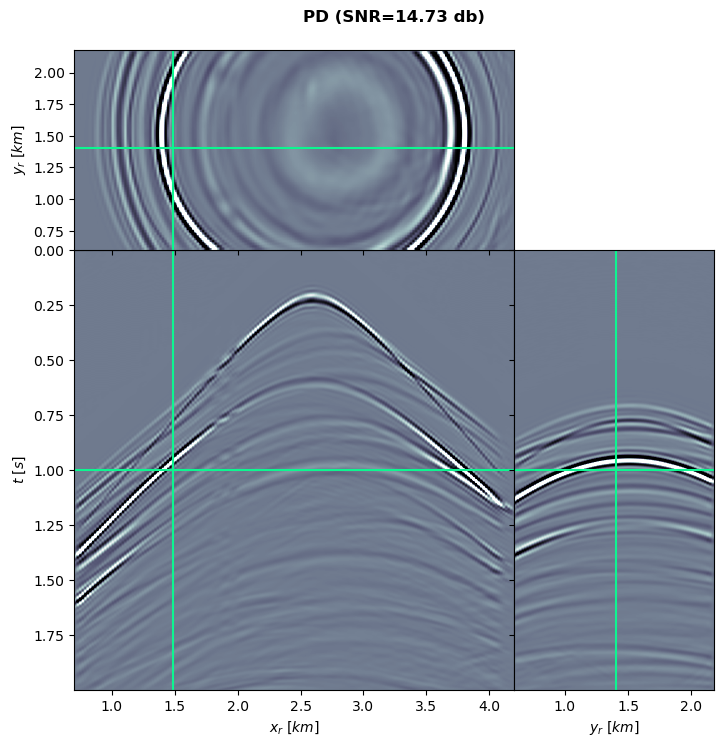

In [26]:
_, snr = metrics(data, direct_mask*datarec_pdshiftedback, itmin=0)
fig, axs = explode_volume(datarec_pdshiftedback.transpose(2, 0, 1) * gain, x=xplot, 
               tlim=[0, t[-1]], tlabel=r'$t$',
               xlim=[recx[0]/1e3, recx[-1]/1e3], xlabel=r'$x_r$',
               ylim=[recy[0]/1e3, recy[-1]/1e3], ylabel=r'$y_r$',
               labels= (r'$[s]$', r'$[km]$', r'$[km]$'),
               clipval=(-0.1,0.1), figsize=(8, 8), title=f'PD (SNR={snr:.2f} db)')
plt.savefig(f'../../figs/Overthrust/Offgrid_PDdata_sliding.eps');

### Comparison with windowed approach

In [27]:
# Load examples with windows
ff = np.load(f'../../experiments/Overthrust/Rec_offgrid{perc_subsampling}_wins.npz')
snr_epocs_win = ff['snr_epocs']
snr_pd_win = ff['snr_pd']
snr_pdinv_win = ff['snr_pdinv']
niter_win = 140
jsrnsave_win = 20

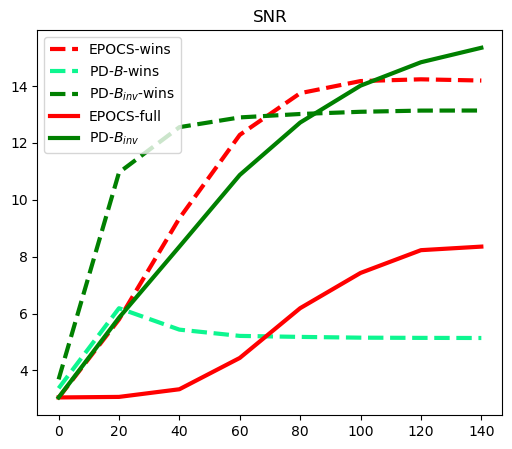

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot(np.arange(0, niter_win+1, jsrnsave_win), snr_epocs_win, '--r', lw=3, label='EPOCS-wins')
ax.plot(np.arange(0, niter_win+1, jsrnsave_win), snr_pd_win, '#0DF690', linestyle='--', lw=3, label='PD-$B$-wins')
ax.plot(np.arange(0, niter_win+1, jsrnsave_win), snr_pdinv_win, '--g', lw=3, label='PD-$B_{inv}$-wins')
ax.plot(np.arange(0, niter+1, jsrnsave), snr_hist_epocs[::jsrnsave], 'r', lw=3, label='EPOCS-full')
ax.plot(np.arange(0, niter+1, jsrnsave), snr_hist_pd[::jsrnsave], 'g', lw=3, label=r'PD-$B_{inv}$')
ax.set_title('SNR')
ax.legend()
plt.savefig(f'../../figs/Overthrust/Offgrid_SNRs.eps', dpi=150, bbox_inches='tight');